## Excersice 3

#### Loading resources

In [1]:
# Loads relevant libraries for excersice
import pandas as pd
import matplotlib

# Loads data from .csv file
hotels = pd.read_csv("hotels_data.csv", low_memory=False)

### Section A

Find 150 hotels which have highest amount of reservations

In [2]:
# Divide data to groups by 'Hotel Name'
hotelsAsGroups = hotels.groupby(['Hotel Name'])

# Count number of reservations with aggregetion
# Then picking an arbitrary column - for working with the counts vector
reservationsCount = hotelsAsGroups.agg(['count'])['Days']

# Sorting and stay with top 150 hotel records
popularHotelsCount = reservationsCount.sort_values(by=['count'], ascending=False).head(150)

# Take only popular hotels data
fHotels = hotels.loc[hotels['Hotel Name'].isin(popularHotelsCount.index)]

In [3]:
popularHotelsCount.count()

count    150
dtype: int64

### Section B

Find from popular 150 hotels the most popular 40 Check-In dates

In [4]:
# Group by check in date
checkInGroups = fHotels.groupby(['Checkin Date'])

# Count number of reservations in each date with aggregetion
# Then picking an arbitrary column - for working with the counts vector
checkInDatesCount = checkInGroups.agg(['count'])['Days']
popCheckInDatesCount = checkInDatesCount.sort_values(by=['count'], ascending=False).head(40)

# Take only popular check-in dates data
fHotels = fHotels.loc[hotels['Checkin Date'].isin(popCheckInDatesCount.index)]

#hotelgrouped = popDatesOnly.groupby(['Hotel Name'])

In [5]:
len(fHotels.groupby(['Checkin Date']))

40

### Section C

Creating DataFrame that saves for each Check-In date, for-each hotel its and for-each discount-code it's price. (if there is no price will be -1)



In [6]:
dateslst = popCheckInDatesCount.index.values

# mapping for each date concat each discount code
codes = [1,2,3,4]
mapDatesWithDiscountCodes = map(lambda date: 
    list(map(lambda code: date + "-" + str(code), codes))
    , dateslst)

# Get it as list, each cell is a list with date-code concating
nestedLst = list(mapDatesWithDiscountCodes)

# Flat data to get only layer of date, again with date-code concat pairs
flatLst = [dateWithCode for dateList in nestedLst for dateWithCode in dateList]

In [7]:
len(flatLst)

160

Sets cluster Data-Frame structure

In [8]:
# Sets a data-frame for saving data
# Record is 'Hotel Name' with all date-code pairs
clusterColumns = ['Hotel Name'] + flatLst
cluster = pd.DataFrame(columns=clusterColumns)

Fill cluster Data-Frame data

In [9]:
cHotelRecords = fHotels.groupby(['Hotel Name'])

# Iterate each grouped hotel
for htlName, htlGroup in cHotelRecords:
    
    # Init new row
    clusterRow = {'Hotel Name': htlName}
    
    currDateGrouped = htlGroup.groupby(['Checkin Date'])
    
    for chkName, chkGroup in currDateGrouped:
        
        dCodeGrouped = htlGroup.groupby(['Discount Code'])
        
        for dCodeName, dCodeGroup in dCodeGrouped:
            
            # Gets lowest price from the same hotel with same discount code
            # on the same date
            rowIdx = dCodeGroup['Discount Price'].idxmin(axis=1)
            lowPrice = dCodeGroup.loc[rowIdx]['Discount Price']
            # Sets that price
            clusterRow[chkName + "-" + str(int(dCodeName))] = lowPrice
    
    # Appending cluster Data-Frame
    cluster = cluster.append(clusterRow, ignore_index=True)

# Fill empty cells with default value [-1]
cluster = cluster.fillna(-1)

## Section D
Normalization

In [26]:
import math

# Normalize according to price range [between 0-100]
def normalize(maxVal, minVal, val):
    if (maxVal == minVal):
        return 100
    else:
        return (float(val - minVal) / (maxVal - minVal)) * 100

# Drops string columns for normalization 
norCluster = cluster.drop('Hotel Name', axis=1)

# Go over rows and normalize each one:
for rowIdx, row in  norCluster.iterrows():
    
    # Reset current maximum and minimum
    currMax = row.max()
    currMin = currMax
    
    # Finds minimum value
    for col in norCluster:
        
        # Checks if current value is not -1 or lower then the current minimum value
        if row[col] != -1 and row[col] < currMin:
            currMin = row[col]
    
    # Normalize row cells
    cluster.iloc[rowIdx,1:161] = cluster.iloc[rowIdx,1:161].apply(lambda val: -1 if val == -1 else normalize(currMax, currMin, val))
    testCluster = cluster

## Section E

Clustering Visualization - dendrogram

In [27]:
norCluster = cluster.drop('Hotel Name', axis=1)

Populating the interactive namespace from numpy and matplotlib


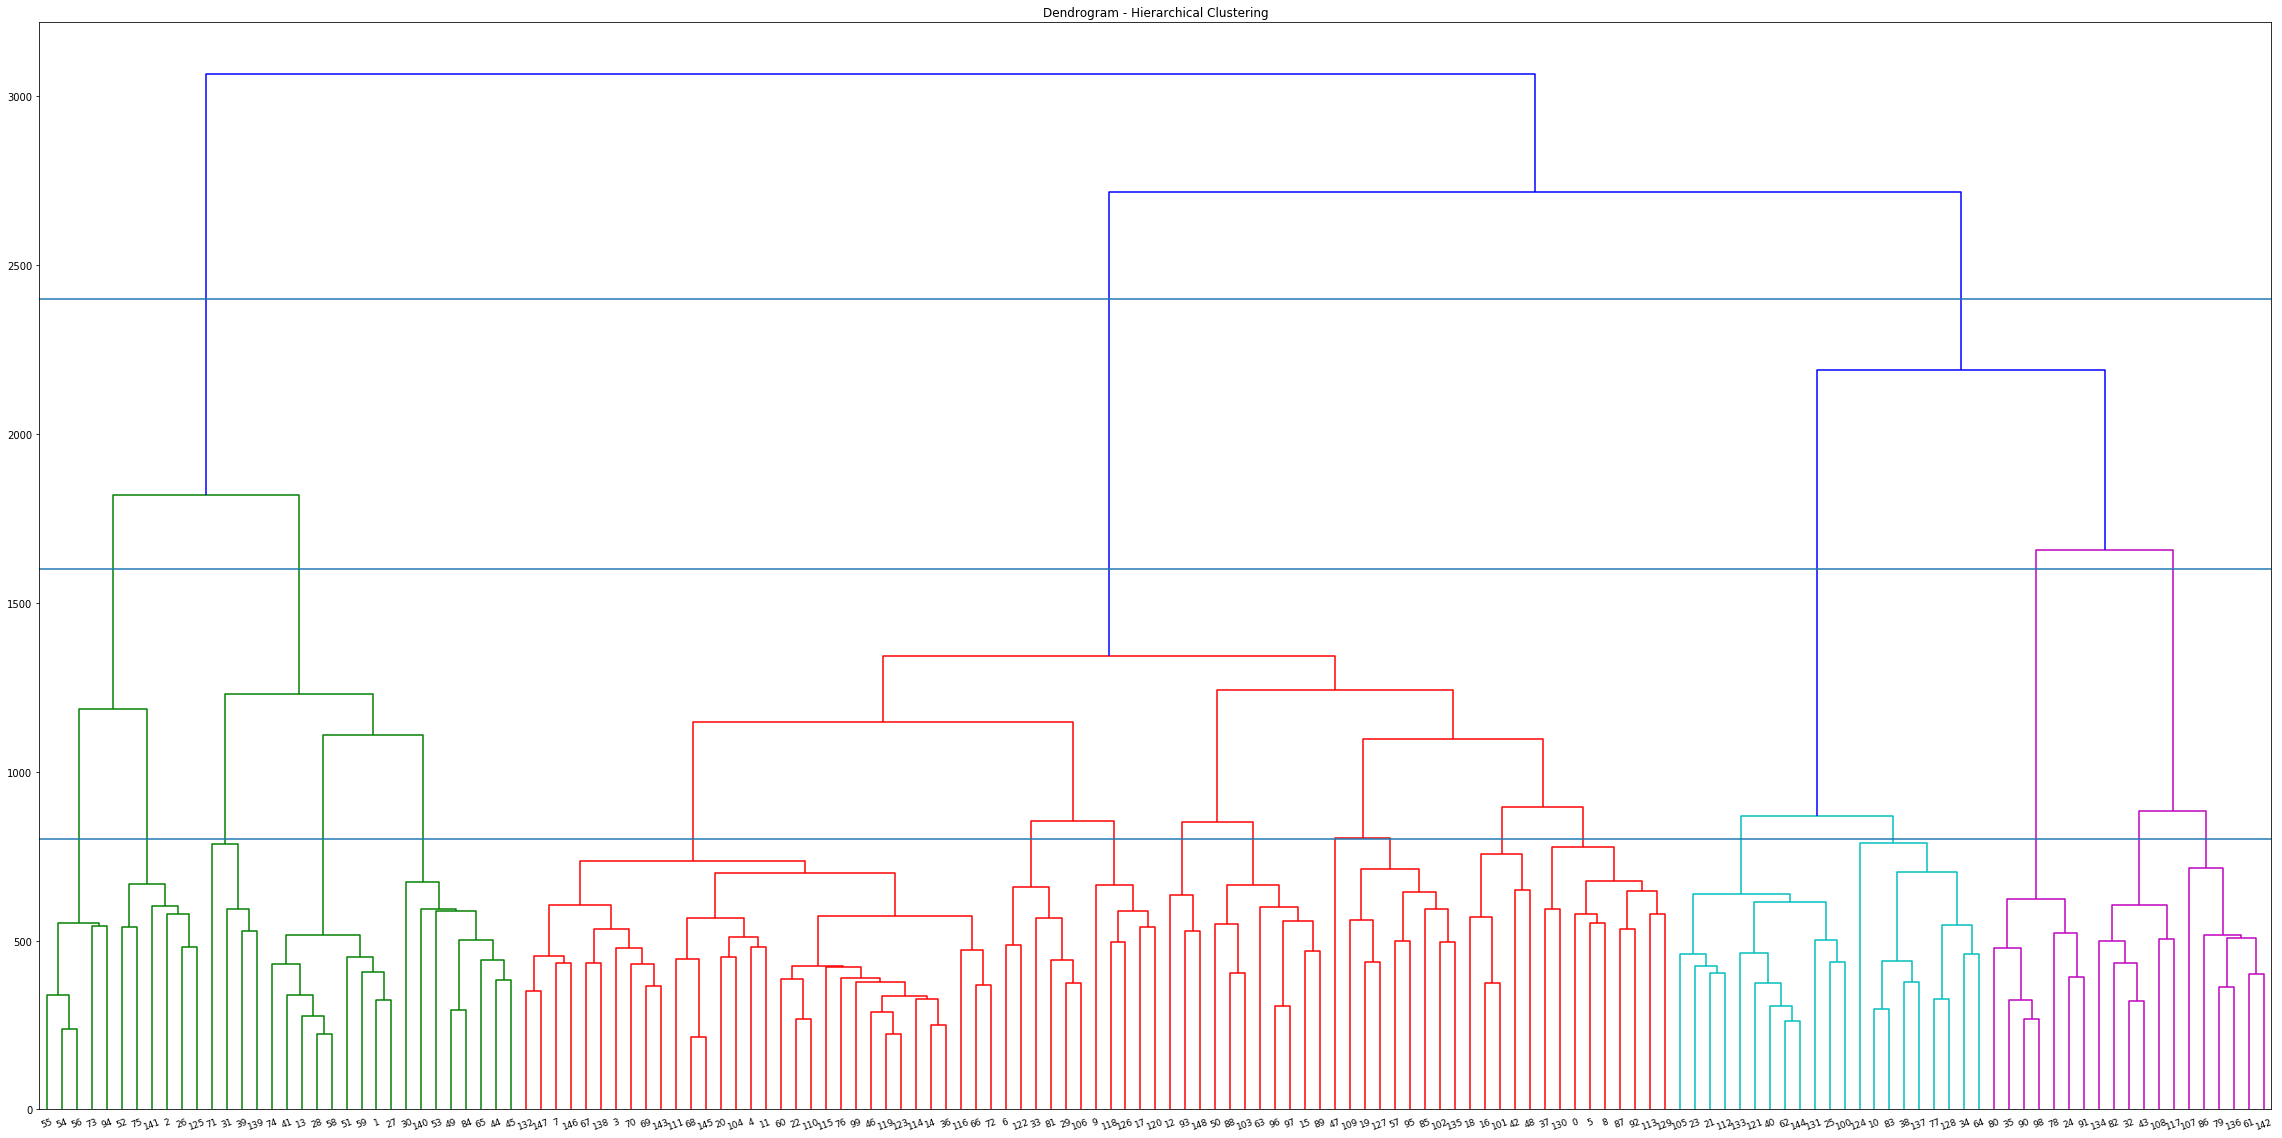

In [28]:
%pylab inline
pylab.rcParams['figure.figsize'] = (40, 20)

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage


linkage_matrix = linkage(norCluster, 'ward')
dendrogram(
    linkage_matrix,
    truncate_mode="lastp",  # display last p merged clusters
    p=149,                  # display last p merged clusters
    show_leaf_counts=True,  # numbers in brackets are counts, others idxs
    leaf_rotation=20.,
    leaf_font_size=9.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('Dendrogram - Hierarchical Clustering')
plt.axhline(y=2400)
plt.axhline(y=1600)
plt.axhline(y=800)
plt.show()

#### Findings from Dendrogram
We have 4 main clusters, 

**Green cluster**  - Most hotels are Hilton & Hampton Inn hotels.

**Red cluster**    - Largest group by far (more than twice in size) - Large variance of samples. Probably a cluster which the dendrogrom make us but it is does not have any meaning.

**Blue cluster**   - Paying policy of having in on of the discount code the maximum cost and in the other a minimum payment. (always have 0 and 100).

**Purple cluster** - Most are at least 4 stars hotels - probably more expensive.

In general, you could use this information to analysis different hotels with the same pricing policy, and find for example the cheapest hotel in it's category only because of this data. (The cheapest at least 4 stars hotel at the list).

In [31]:
#cluster.loc[[55,54,56,73,94,52,75,141,2,26,125,71,31,39,139,74,41,13,28,58,51,59,1,27,30,140,53,49,84,65,44,45]]

In [33]:
cluster.loc[[105,23,21,112,133,121,40,62,144,131,25,100,124,10,83,38,137,77,128,34,64]]

,Hotel Name,11/11/2015 0:00-1,11/11/2015 0:00-2,11/11/2015 0:00-3,11/11/2015 0:00-4,10/14/2015 0:00-1,10/14/2015 0:00-2,10/14/2015 0:00-3,10/14/2015 0:00-4,11/4/2015 0:00-1,...,11/3/2015 0:00-3,11/3/2015 0:00-4,8/13/2015 0:00-1,8/13/2015 0:00-2,8/13/2015 0:00-3,8/13/2015 0:00-4,11/25/2015 0:00-1,11/25/2015 0:00-2,11/25/2015 0:00-3,11/25/2015 0:00-4
105,Shelburne NYC-an Affinia hotel,29.166667,0.000000,32.812500,100.0,29.166667,0.000000,32.812500,100.0,29.166667,...,32.812500,100.0,29.166667,0.000000,32.812500,100.0,29.166667,0.000000,32.812500,100.0
23,DoubleTree Suites by Hilton New York City - Ti...,5.498282,4.810997,0.000000,100.0,-1.000000,-1.000000,-1.000000,-1.0,5.498282,...,-1.000000,-1.0,5.498282,4.810997,0.000000,100.0,-1.000000,-1.000000,-1.000000,-1.0
21,Crowne Plaza Times Square Manhattan,0.000000,24.218750,28.906250,100.0,0.000000,24.218750,28.906250,100.0,0.000000,...,28.906250,100.0,0.000000,24.218750,28.906250,100.0,-1.000000,-1.000000,-1.000000,-1.0
112,The Benjamin,0.000000,10.164425,24.962631,100.0,-1.000000,-1.000000,-1.000000,-1.0,0.000000,...,24.962631,100.0,0.000000,10.164425,24.962631,100.0,-1.000000,-1.000000,-1.000000,-1.0
133,The Towers of the Waldorf Astoria New York,22.727273,39.772727,0.000000,100.0,22.727273,39.772727,0.000000,100.0,22.727273,...,0.000000,100.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.0
121,The New York EDITION,-1.000000,0.000000,0.000000,100.0,-1.000000,0.000000,0.000000,100.0,-1.000000,...,0.000000,100.0,-1.000000,0.000000,0.000000,100.0,-1.000000,0.000000,0.000000,100.0
40,Hampton Inn Manhattan Soho,18.181818,0.000000,27.272727,100.0,18.181818,0.000000,27.272727,100.0,-1.000000,...,-1.000000,-1.0,18.181818,0.000000,27.272727,100.0,18.181818,0.000000,27.272727,100.0
62,Hilton Times Square,21.180556,10.416667,0.000000,100.0,21.180556,10.416667,0.000000,100.0,21.180556,...,0.000000,100.0,21.180556,10.416667,0.000000,100.0,21.180556,10.416667,0.000000,100.0
144,Wyndham Garden Brooklyn Sunset Park,3.780069,0.000000,4.123711,100.0,3.780069,0.000000,4.123711,100.0,3.780069,...,4.123711,100.0,3.780069,0.000000,4.123711,100.0,3.780069,0.000000,4.123711,100.0
131,The Standard East Village,22.195704,61.575179,0.000000,100.0,22.195704,61.575179,0.000000,100.0,22.195704,...,0.000000,100.0,22.195704,61.575179,0.000000,100.0,22.195704,61.575179,0.000000,100.0
